In [1]:
import re
import numpy as np
import pandas as pd

import tensorflow as tf

from sklearn.model_selection import train_test_split

2024-04-12 10:47:09.433783: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 10:47:10.241353: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
txt_file = 'data/kor_dance_bigram.txt'
raw_corpus = []

with open(txt_file, 'r', encoding = 'utf-8') as f:
    raw = f.read().splitlines()
    raw_corpus.extend(raw)
print(len(raw_corpus))

178203


In [3]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()                         #소문자 변경 후 양쪽 공백 제거
    sentence = re.sub(r"([?.!,¿]).,", r" \1 ", sentence)          #특수문자 양쪽에 공백 추가
    sentence = re.sub(r'[" "]+', " ", sentence)                 #여러 개의 공백이 붙어있으면 하나의 공백으로
    sentence = re.sub(r"[^a-zA-Z가-힣?!¿_]+", " ", sentence)   #영어, 알파벳, ?, !, ¿ 제외 모두 공백으로
    sentence = sentence.strip()                                 #양쪽 공백 제거
    sentence = re.sub(r"\(.\)", " ", sentence)                  #괄호 제거
    sentence = '<start> ' + sentence + ' <end>'                 #start, end 추가
    return sentence

In [4]:
corpus = []
for sentence in raw_corpus:
    if len(sentence) == 0:
        continue
    if sentence[-1] == ':':
        continue
    if len(sentence)>150:
        continue

    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)

print(len(corpus))
print(corpus[:10])

178201
['<start> 오늘도 아침엔 입에 빵을 물고 <end>', '<start> 똑같이 하루를 시작하고 <end>', '<start> 온종일 한 손엔 아이스 아메리카노 <end>', '<start> 피곤해 죽겠네 <end>', '<start> 지하철 속 이 장면 어제 꿈에서 봤나 <end>', '<start> 아참 매일이지 지나치고 <end>', '<start> 바쁜 이 삶에 그냥 흔한 날에 <end>', '<start> 그 애를 보고 말야 <end>', '<start> 평온했던 하늘이 무너지고 <end>', '<start> 어둡던 눈앞이 붉어지며 <end>']


In [5]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = 30000, filters = ' ', oov_token = '<unk>')
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding = 'post')
    print('토크나이저: ', tokenizer, '\n', tensor)

    return tensor, tokenizer

In [6]:
tensor, tokenizer = tokenize(corpus)

토크나이저:  <keras.src.legacy.preprocessing.text.Tokenizer object at 0x7ff80ff8df50> 
 [[    2   236  8345 ...     0     0     0]
 [    2  3318   816 ...     0     0     0]
 [    2  1241    88 ...     0     0     0]
 ...
 [    2 20516  1447 ...     0     0     0]
 [    2     4 14682 ...     0     0     0]
 [    2  4747    99 ...     0     0     0]]


In [7]:
tensor.shape

(178201, 19)

In [8]:
for idx in tokenizer.index_word:
    print(idx, ':', tokenizer.index_word[idx])
    if idx>=20: break

1 : <unk>
2 : <start>
3 : <end>
4 : you
5 : i
6 : 난
7 : 내
8 : 날
9 : oh
10 : me
11 : it
12 : 내가
13 : 널
14 : 그
15 : love
16 : baby
17 : 나
18 : 더
19 : 나를
20 : 넌


In [9]:
#소스 문장과 타겟 문장으로 1차 분리
#tensor에서 마지막 토큰을 잘라내어 소스 문장을, 첫번째 start를 잘라내어 타겟 문장을 생성
#LSTM에서 many-to-many의 답을 얻을 것이므로 위와 같이 구성 <- ????
#이 과정을 통해 src_input과 tgt_input 길이 동일
src_input = tensor[:, :-1]      #start+sentence+end+padding n-1개
tgt_input = tensor[:, 1:]       #sentence+end+padding n개
print('텐서 길이: ', tensor.shape)
print('소스문장 길이: ', len(src_input[0]))
print('타겟문장 길이: ', len(tgt_input[0]))

텐서 길이:  (178201, 19)
소스문장 길이:  18
타겟문장 길이:  18


In [10]:
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size = 0.2, random_state = 1234)
print('Source Train 길이: ', enc_train.shape)
print('Target Train 길이: ', dec_train.shape)
print('Source Test 길이: ', enc_val.shape)
print('Target Test 길이: ', dec_val.shape)

Source Train 길이:  (142560, 18)
Target Train 길이:  (142560, 18)
Source Test 길이:  (35641, 18)
Target Test 길이:  (35641, 18)


In [11]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epochs = len(src_input) // BATCH_SIZE
VOCAB_SIZE = tokenizer.num_words + 1

dataset_train = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
dataset_train = dataset_train.shuffle(BUFFER_SIZE)
dataset_train = dataset_train.batch(BATCH_SIZE, drop_remainder = True)

dataset_val = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
dataset_val = dataset_val.shuffle(BUFFER_SIZE)
dataset_val = dataset_val.batch(BATCH_SIZE, drop_remainder = True)

print(dataset_train)
print(dataset_val)

2024-04-12 10:47:32.700228: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


<_BatchDataset element_spec=(TensorSpec(shape=(256, 18), dtype=tf.int32, name=None), TensorSpec(shape=(256, 18), dtype=tf.int32, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(256, 18), dtype=tf.int32, name=None), TensorSpec(shape=(256, 18), dtype=tf.int32, name=None))>


2024-04-12 10:47:32.743849: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-12 10:47:32.744057: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-12 10:47:32.745035: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [12]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)      #vocab_size로 입력되어서 그걸 embedding_size 만큼으로 표현할 것
        self.rnn_1 = tf.keras.layers.SimpleRNN(hidden_size, return_sequences = True)
        self.rnn_2 = tf.keras.layers.SimpleRNN(hidden_size, return_sequences = True)
        self.linear = tf.keras.layers.Dense(vocab_size)     #vocab_size로 줄여야 다음에 무슨 단어를 낼지에 대한 각 클래스 별 수치가 출력

    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)

        return out

In [13]:
embedding_size = 256    #word embedding 차원 수. 즉, 단어가 추상적으로 표현되는 크기 -> dataset의 shape과 같아야 하는거 아닌지???
hidden_size = 1024      #hidden state의 차원 수
model = TextGenerator(tokenizer.num_words + 1, embedding_size, hidden_size)
model

<TextGenerator name=text_generator, built=False>

In [14]:
for src_sample, tgt_sample in dataset_train.take(1): break
model(src_sample)

<tf.Tensor: shape=(256, 18, 30001), dtype=float32, numpy=
array([[[ 1.34485289e-02,  7.37704861e-04, -1.10689097e-03, ...,
         -4.79684025e-03,  5.02663758e-03,  4.82551102e-03],
        [-4.45710635e-03,  1.29339809e-04, -2.33667367e-03, ...,
          3.31345899e-03,  1.28747728e-02,  4.29498870e-03],
        [ 4.18702140e-03, -1.34463739e-02,  1.35396505e-02, ...,
          1.08654108e-02,  5.07969549e-03, -1.12007083e-02],
        ...,
        [-7.80501636e-03, -2.88484190e-02, -2.65106419e-03, ...,
         -5.81858754e-02, -6.18882850e-02,  5.21662273e-03],
        [ 8.93515302e-04,  4.47200723e-02, -3.11864093e-02, ...,
         -3.06488257e-02, -7.53278518e-03,  1.39131090e-02],
        [ 4.76406626e-02, -4.45314310e-02,  1.11567248e-02, ...,
          8.17428753e-02, -4.80782576e-02, -1.18144872e-02]],

       [[ 1.34485289e-02,  7.37704861e-04, -1.10689097e-03, ...,
         -4.79684025e-03,  5.02663758e-03,  4.82551102e-03],
        [-3.11091635e-03,  4.16865991e-03, -3

In [15]:
model.summary()

Model: "text_generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     7,680,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │    30,751,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,841,201 (159.61 MB)

 Trainable params: 41,841,201 (159.61 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [17]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = 'none')

In [18]:
model.compile(loss = loss, optimizer = optimizer)
model.fit(dataset_train, epochs = 10)

Epoch 1/10


I0000 00:00:1712918868.764365  514224 service.cc:145] XLA service 0x7ff750002ee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1712918868.764416  514224 service.cc:153]   StreamExecutor device (0): NVIDIA A16-16Q, Compute Capability 8.6
2024-04-12 10:47:48.823733: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-12 10:47:49.356063: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1712918870.235703  514285 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_61', 84 bytes spill stores, 84 bytes spill loads

I0000 00:00:1712918871.569527  514290 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_61', 1740 bytes spill stores, 2152 bytes spill loads

I0000 00:00:1712918

556/556 ━━━━━━━━━━━━━━━━━━━━ 143s 240ms/step - loss: 2.2493
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 135s 242ms/step - loss: 1.6391
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 135s 242ms/step - loss: 1.4775
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 135s 242ms/step - loss: 1.3191
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 135s 242ms/step - loss: 1.1669
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 135s 242ms/step - loss: 1.0490
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 135s 242ms/step - loss: 0.9719
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 135s 242ms/step - loss: 0.9159
Epoch 9/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 135s 242ms/step - loss: 0.8780
Epoch 10/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 135s 242ms/step - loss: 0.8501


In [19]:
model.save('rnn_kor_dance_bigram.keras')
model.save('rnn_kor_dance_bigram.h5')
tf.saved_model.save(model, 'rnn_kor_dance_bigram.tf')

INFO:tensorflow:Assets written to: rnn_kor_dance_bigram.tf/assets


INFO:tensorflow:Assets written to: rnn_kor_dance_bigram.tf/assets


In [20]:
def generate_text(model, tokenizer, init_sentence = '<start>', max_len = 30):
    #테스트를 위해 입력받은 init_sentence도 텐서 변환
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype = tf.int64)
    end_token = tokenizer.word_index['<end>']

    #단어를 하나씩 예측해 문장 생성
    while True:
        #1. 입력받은 문장의 텐서 입력
        predict = model(test_tensor)
        #2. 예측된 값 중 가장 높은 확률인 word index를 출력
        predict_word = tf.argmax(tf.nn.softmax(predict, axis = -1), axis = -1)[:, -1]
        #3. 2에서 예측된 word index를 문장 뒤에 붙임
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis = 0)], axis = -1)
        #4. 모델이 <end>를 예측했거나 max_len에 도달하면 문장 생성을 마침
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ''
    #tokenizer를 활용해 word index를 단어로 하나씩 변환
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + ' '

    return generated

In [21]:
generate_text(model, tokenizer, init_sentence = '<start> i')

'<start> i m ridin that new wave <end> '

In [22]:
generate_text(model, tokenizer, init_sentence = '<start> 나')

'<start> 나 <unk> <unk> <end> '

In [23]:
generate_text(model, tokenizer, init_sentence = '<start> 나', max_len = 50)

'<start> 나 <unk> <unk> <end> '

In [24]:
generate_text(model, tokenizer, init_sentence = '<start> 사랑해')

'<start> 사랑해 너_밖엔 없더라 <end> '

In [25]:
generate_text(model, tokenizer, init_sentence = '<start> 사랑은')

'<start> 사랑은 move_move <end> '

In [26]:
generate_text(model, tokenizer, init_sentence = '<start> 사랑이')

'<start> 사랑이 <unk> <end> '

dance_epex - 청춘에게  
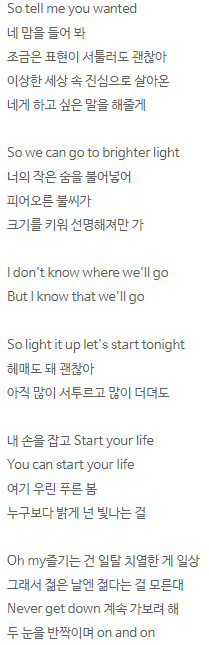

In [27]:
youth = ['so', '네', '마음', '조금은', '이상한', '네게', '너의', '피어오른', '크기를', 'i']
for word in youth:
    word = '<start> ' + word
    print(generate_text(model, tokenizer, init_sentence = word))

<start> so i m just singing tonight <end> 
<start> 네 사랑에_빠질래 <end> 
<start> 마음 <unk> <end> 
<start> 조금은 위험해_위험해 위험해도 <end> 


<start> 이상한 일들 정말 부담 <unk> <end> 
<start> 네게 달려 가는_중 <end> 
<start> 너의 손길 필요해 <end> 
<start> 피어오른 you <end> 
<start> <unk> <unk> <end> 
<start> i m ridin that new wave <end> 


all genre_임수-goood  
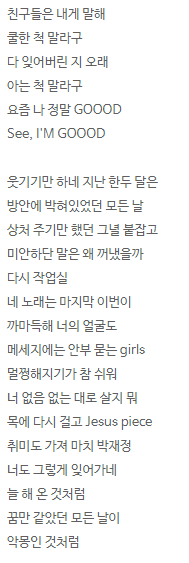

In [28]:
goood = ['친구들은', '쿨한', '다', '아는', '요즘', 'see', '웃기기만', '방안에', '상처', '미안하단']
for word in goood:
    word = '<start> ' + word
    print(generate_text(model, tokenizer, init_sentence = word))

<start> 친구들은 애인이 싫은 건지 <end> 
<start> 쿨한 미소는 너의 <unk> <end> 
<start> 다 사라질 <unk> <end> 


<start> 아는 향길 <unk> 뿐야 <end> 
<start> 요즘 세상엔 왜_그리도 <end> 
<start> see ya <end> 
<start> <unk> <unk> <end> 
<start> 방안에 있어도 거실에 나가도 <end> 
<start> 상처 <unk> <end> 
<start> 미안하단 말은 하는데 <end> 


: 